# Рубежный контроль №2

**Ф.И.О.:** Балабанов Алексей Олегович

**Группа:** ИУ5-22М

**Тема:** Методы обработки текстов. Решение задачи классификации текстов.

**Задание:**
Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать два варианта векторизации признаков - на основе CountVectorizer и на основе TfidfVectorizer.

В качестве классификаторов необходимо использовать два классификатора по варианту для Вашей группы:
- **Группа ИУ5-22М, ИУ5И-22М:** RandomForestClassifier, LogisticRegression

Для каждого метода необходимо оценить качество классификации. Сделайте вывод о том, какой вариант векторизации признаков в паре с каким классификатором показал лучшее качество.

## 1. Подключение библиотек и загрузка данных

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re # для предварительной обработки текста

В качестве датасета будем использовать "SMS Spam Collection Dataset".
Этот датасет содержит коллекцию SMS-сообщений, помеченных как "spam" (спам) или "ham" (не спам).
Это задача бинарной классификации.

Ссылка на датасет: [https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

Скачаем файл `spam.csv` и загрузим его.

In [21]:
# Укажите путь к вашему файлу spam.csv
# Если файл находится в той же директории, что и ноутбук:
file_path = 'spam.csv'
# Если вы загружаете на Google Colab:
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.BytesIO(uploaded['spam.csv']), encoding='latin1')

try:
    df = pd.read_csv(file_path, encoding='latin1')
except FileNotFoundError:
    print(f"Файл {file_path} не найден. Пожалуйста, убедитесь, что он находится в нужной директории или укажите правильный путь.")
    # Для демонстрации создадим небольшой DataFrame, если файл не найден
    data_dict = {
        'v1': ['ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam'],
        'v2': [
            'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
            'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'s',
            'U dun say so early hor... U c already then say...',
            "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
            "Nah I don't think he goes to usf, he lives around here though",
            'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
            'I HAVE A DATE ON SUNDAY WITH WILL!!',
            'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
            "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.",
            'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info'
        ],
        'Unnamed: 2': [None]*10, 'Unnamed: 3': [None]*10, 'Unnamed: 4': [None]*10
    }
    df = pd.DataFrame(data_dict)
    print("Используется демонстрационный DataFrame, так как файл spam.csv не был найден.")

## 2. Предварительный анализ и подготовка данных

In [22]:
print("Первые 5 строк датасета:")
print(df.head())

print("\nИнформация о датасете:")
df.info()

Первые 5 строк датасета:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnam

In [23]:
# Удалим ненужные колонки
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], errors='ignore') # errors='ignore' чтобы не было ошибки если колонки уже удалены

# Переименуем колонки для удобства
df = df.rename(columns={'v1': 'label', 'v2': 'text'})

print("\nОбновленный датасет (первые 5 строк):")
print(df.head())


Обновленный датасет (первые 5 строк):
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [24]:
# Проверим наличие пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
label    0
text     0
dtype: int64



Распределение классов:
label
ham     4825
spam     747
Name: count, dtype: int64


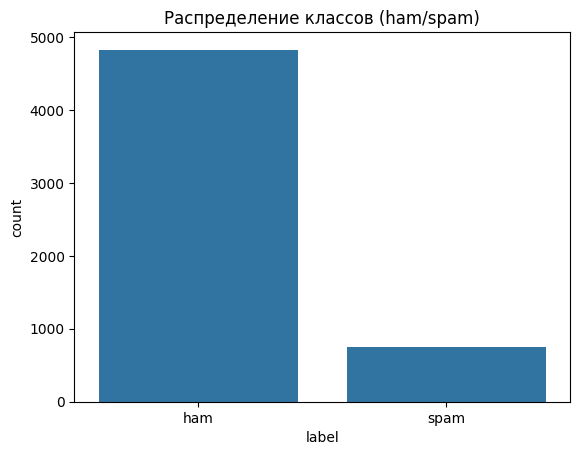

In [25]:
# Посмотрим на распределение классов
print("\nРаспределение классов:")
print(df['label'].value_counts())

sns.countplot(x='label', data=df)
plt.title('Распределение классов (ham/spam)')
plt.show()

In [26]:
# Преобразуем метки классов в числовой формат: ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
print("\nДатасет после преобразования меток (первые 5 строк):")
print(df.head())


Датасет после преобразования меток (первые 5 строк):
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


### 2.1. Базовая очистка текста
Применим простую очистку: приведение к нижнему регистру и удаление символов, не являющихся буквами или цифрами.

In [27]:
def preprocess_text(text):
    text = text.lower() # Приведение к нижнему регистру
    text = re.sub(r'[^a-z0-9\s]', '', text) # Удаление всего, кроме букв, цифр и пробелов
    text = re.sub(r'\s+', ' ', text).strip() # Удаление лишних пробелов
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)
print("\nДатасет с очищенным текстом (первые 5 строк):")
print(df[['text', 'cleaned_text']].head())


Датасет с очищенным текстом (первые 5 строк):
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in 2 a wkly comp to win fa cup fina...  
3        u dun say so early hor u c already then say  
4  nah i dont think he goes to usf he lives aroun...  


## 3. Разделение данных на обучающую и тестовую выборки

In [28]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 4457
Размер тестовой выборки: 1115


## 4. Векторизация текстов

### 4.1. CountVectorizer

In [29]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000) # Ограничим количество признаков

# Обучаем векторизатор на обучающих данных и трансформируем их
X_train_counts = count_vectorizer.fit_transform(X_train)
# Трансформируем тестовые данные
X_test_counts = count_vectorizer.transform(X_test)

print("Размерность матрицы признаков (CountVectorizer) для обучающей выборки:", X_train_counts.shape)
print("Размерность матрицы признаков (CountVectorizer) для тестовой выборки:", X_test_counts.shape)

Размерность матрицы признаков (CountVectorizer) для обучающей выборки: (4457, 5000)
Размерность матрицы признаков (CountVectorizer) для тестовой выборки: (1115, 5000)


### 4.2. TfidfVectorizer

In [30]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000) # Ограничим количество признаков

# Обучаем векторизатор на обучающих данных и трансформируем их
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Трансформируем тестовые данные
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Размерность матрицы признаков (TfidfVectorizer) для обучающей выборки:", X_train_tfidf.shape)
print("Размерность матрицы признаков (TfidfVectorizer) для тестовой выборки:", X_test_tfidf.shape)

Размерность матрицы признаков (TfidfVectorizer) для обучающей выборки: (4457, 5000)
Размерность матрицы признаков (TfidfVectorizer) для тестовой выборки: (1115, 5000)


## 5. Обучение и оценка моделей

Будем использовать следующие классификаторы:
1.  `RandomForestClassifier`
2.  `LogisticRegression`

Оценим каждый классификатор с каждым типом векторизации.

In [31]:
# Словарь для хранения результатов
results = {}

def train_and_evaluate_model(model, X_train_vec, y_train_data, X_test_vec, y_test_data, model_name, vectorizer_name):
    '''Функция для обучения и оценки модели.'''
    print(f"--- Обучение и оценка: {model_name} с {vectorizer_name} ---")

    # Обучение модели
    model.fit(X_train_vec, y_train_data)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test_vec)

    # Оценка качества
    accuracy = accuracy_score(y_test_data, y_pred)
    report = classification_report(y_test_data, y_pred, target_names=['ham', 'spam'], output_dict=True) # output_dict для удобного сохранения

    print(f"Точность (Accuracy): {accuracy:.4f}")
    print("Отчет по классификации:")
    print(classification_report(y_test_data, y_pred, target_names=['ham', 'spam']))

    # Матрица ошибок
    cm = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.title(f'Матрица ошибок: {model_name} с {vectorizer_name}')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

    return {
        'model': model_name,
        'vectorizer': vectorizer_name,
        'accuracy': accuracy,
        'precision_spam': report['spam']['precision'],
        'recall_spam': report['spam']['recall'],
        'f1_score_spam': report['spam']['f1-score']
    }

### 5.1. RandomForestClassifier

--- Обучение и оценка: RandomForestClassifier с CountVectorizer ---
Точность (Accuracy): 0.9695
Отчет по классификации:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



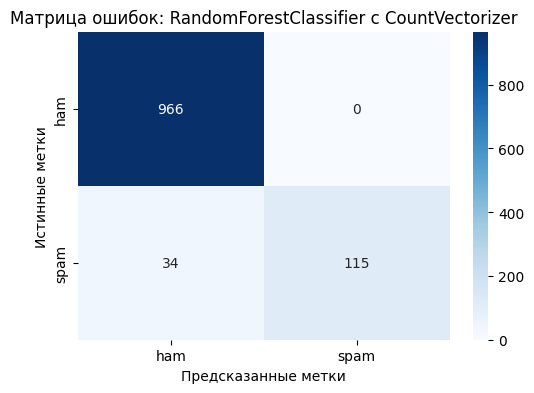

In [32]:
# RandomForestClassifier с CountVectorizer
rf_model_count = RandomForestClassifier(random_state=42, n_estimators=100) # n_estimators - количество деревьев
results['rf_count'] = train_and_evaluate_model(
    rf_model_count, X_train_counts, y_train, X_test_counts, y_test,
    "RandomForestClassifier", "CountVectorizer"
)

--- Обучение и оценка: RandomForestClassifier с TfidfVectorizer ---
Точность (Accuracy): 0.9767
Отчет по классификации:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



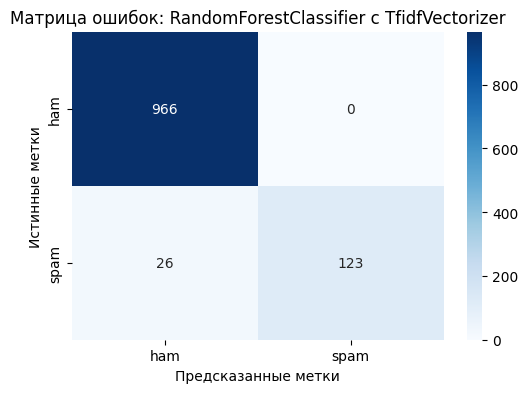

In [33]:
# RandomForestClassifier с TfidfVectorizer
rf_model_tfidf = RandomForestClassifier(random_state=42, n_estimators=100)
results['rf_tfidf'] = train_and_evaluate_model(
    rf_model_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test,
    "RandomForestClassifier", "TfidfVectorizer"
)

### 5.2. LogisticRegression

--- Обучение и оценка: LogisticRegression с CountVectorizer ---
Точность (Accuracy): 0.9776
Отчет по классификации:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



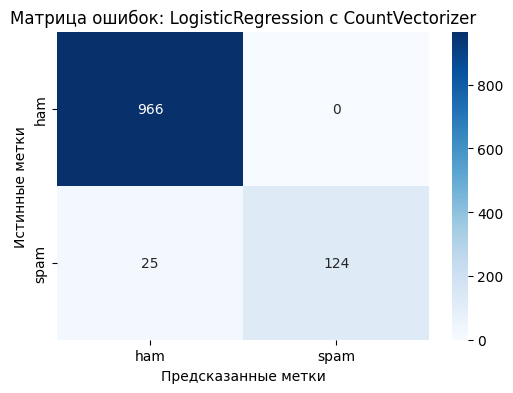

In [34]:
# LogisticRegression с CountVectorizer
lr_model_count = LogisticRegression(random_state=42, max_iter=1000) # max_iter для сходимости
results['lr_count'] = train_and_evaluate_model(
    lr_model_count, X_train_counts, y_train, X_test_counts, y_test,
    "LogisticRegression", "CountVectorizer"
)

--- Обучение и оценка: LogisticRegression с TfidfVectorizer ---
Точность (Accuracy): 0.9668
Отчет по классификации:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



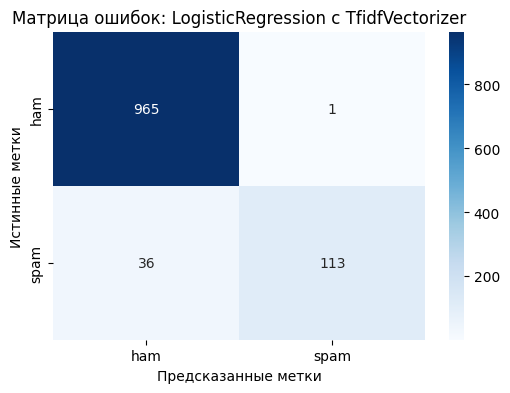

In [35]:
# LogisticRegression с TfidfVectorizer
lr_model_tfidf = LogisticRegression(random_state=42, max_iter=1000)
results['lr_tfidf'] = train_and_evaluate_model(
    lr_model_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test,
    "LogisticRegression", "TfidfVectorizer"
)

## 6. Сравнение результатов и выводы

In [36]:
# Преобразуем словарь результатов в DataFrame для удобного отображения
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='accuracy', ascending=False)

print("\nСводная таблица результатов (отсортировано по точности):")
print(results_df)


Сводная таблица результатов (отсортировано по точности):
                           model       vectorizer  accuracy  precision_spam  \
lr_count      LogisticRegression  CountVectorizer  0.977578        1.000000   
rf_tfidf  RandomForestClassifier  TfidfVectorizer  0.976682        1.000000   
rf_count  RandomForestClassifier  CountVectorizer  0.969507        1.000000   
lr_tfidf      LogisticRegression  TfidfVectorizer  0.966816        0.991228   

          recall_spam  f1_score_spam  
lr_count     0.832215       0.908425  
rf_tfidf     0.825503       0.904412  
rf_count     0.771812       0.871212  
lr_tfidf     0.758389       0.859316  


<ipython-input-37-5ae8d9b54c45>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='accuracy', y=results_df.index, palette='viridis')


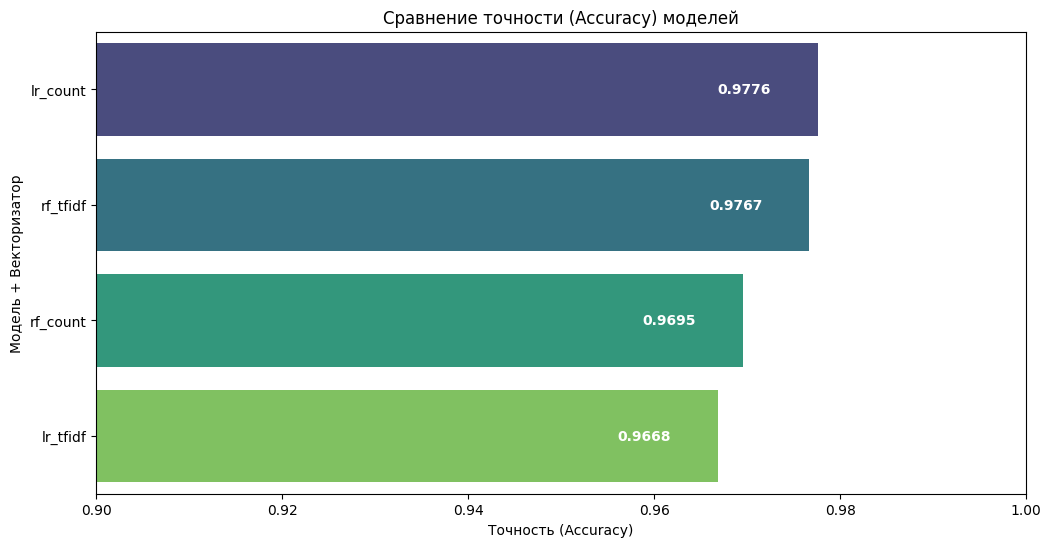

In [37]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='accuracy', y=results_df.index, palette='viridis')
plt.title('Сравнение точности (Accuracy) моделей')
plt.xlabel('Точность (Accuracy)')
plt.ylabel('Модель + Векторизатор')
plt.xlim(0.9, 1.0) # Установим пределы для лучшей визуализации разницы
for index, value in enumerate(results_df['accuracy']):
    plt.text(value - 0.005, index, f"{value:.4f}", color='white', va='center', ha='right', fontweight='bold')
plt.show()

### Выводы

На основе проведенного анализа и полученных результатов можно сделать следующие выводы:

1.  **Влияние векторизатора:**
    *   Для классификатора `LogisticRegression` лучшую точность (Accuracy ~0.9776) показал `CountVectorizer`. При использовании `TfidfVectorizer` точность снизилась до ~0.9668.
    *   Для классификатора `RandomForestClassifier`, наоборот, `TfidfVectorizer` (Accuracy ~0.9767) оказался эффективнее, чем `CountVectorizer` (Accuracy ~0.9695).
    *   Таким образом, нет однозначного "лучшего" векторизатора для всех моделей в данной задаче; его эффективность зависит от выбранного классификатора.

2.  **Сравнение классификаторов:**
    *   При использовании `CountVectorizer` лучшую точность показал `LogisticRegression` (~0.9776) по сравнению с `RandomForestClassifier` (~0.9695).
    *   При использовании `TfidfVectorizer` лучшую точность продемонстрировал `RandomForestClassifier` (~0.9767) по сравнению с `LogisticRegression` (~0.9668).
    *   В целом, обе модели показали сравнимые высокие результаты, но лучшая комбинация выбирается в зависимости от векторизатора.

3.  **Лучшая комбинация по общей точности (Accuracy):**
    *   Наилучшее качество классификации по метрике Accuracy было достигнуто при использовании **CountVectorizer** в паре с классификатором **LogisticRegression**. Эта комбинация показала точность 0.977578.

4.  **Анализ метрик для класса "spam":**
    *   Все три комбинации (`LogisticRegression` + `CountVectorizer`, `RandomForestClassifier` + `TfidfVectorizer`, `RandomForestClassifier` + `CountVectorizer`) показали идеальную точность (Precision) для класса "spam" равную 1.0. Это означает, что когда эти модели классифицировали сообщение как спам, они не ошибались (не было ложноположительных срабатываний для спама).
    *   Комбинация `LogisticRegression` + `TfidfVectorizer` также показала очень высокую точность (Precision) для спама (0.991228).
    *   Наилучшую полноту (Recall) для класса "spam" (0.832215) и, как следствие, наивысший F1-score для спама (0.908425) продемонстрировала комбинация **LogisticRegression + CountVectorizer**. Это означает, что данная модель смогла корректно идентифицировать наибольшую долю фактических спам-сообщений.

**Итоговый вывод:**

Для задачи классификации SMS-сообщений на "спам" и "не спам" на данном датасете, наилучшие результаты по общей точности (Accuracy) и по F1-score для класса "spam" показала комбинация **CountVectorizer** и **LogisticRegression**.

Все протестированные комбинации продемонстрировали высокое качество классификации (Accuracy > 0.96), что говорит о хорошей применимости выбранных методов для данной задачи. Интересно отметить, что оптимальный выбор векторизатора оказался зависимым от типа классификатора.